In [1]:
import tensorflow as tf

/home/yash/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from scipy import io as spio
import keras
import numpy as np

Using TensorFlow backend.


In [3]:
emnist = spio.loadmat("matlab/emnist-byclass.mat")

In [4]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

In [5]:
# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

In [6]:
# store labels for visualization
train_labels = y_train
test_labels = y_test

In [7]:
y_train = keras.utils.to_categorical(y_train, 62) 
y_test = keras.utils.to_categorical(y_test, 62)



In [47]:
class Dataset:
    
    def __init__(self,data):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._num_examples = data.shape[0]
        pass


    @property
    def data(self):
        return self._data

    def next_batch(self,batch_size,shuffle = True):
        
        start = self._index_in_epoch
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._data = self.data[idx]  # get list of `num` random samples

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            return np.concatenate((data_rest_part, data_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end]

dataset = Dataset(np.arange(0, 10))
for i in range(10):
     print(dataset.next_batch(5))

[6 4 5 7 2]
[0 9 1 3 8]
[5 8 0 4 1]
[7 6 3 2 9]
[5 0 4 1 2]
[8 7 9 3 6]
[9 0 8 7 2]
[5 4 3 1 6]
[7 6 0 4 2]
[8 5 9 3 1]


In [9]:
# normalize
x_train /= 255
x_test /= 255

In [10]:
# reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order="A")
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order="A")

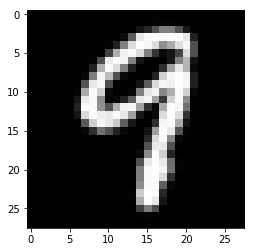

In [17]:
samplenum=546
import matplotlib.pyplot as plt
%matplotlib inline
img = x_train[samplenum]

# visualize image
plt.imshow(img[0], cmap='gray')

In [ ]:
y = Dataset(y_train)
x = Dataset(x_train)

### helper functions

In [21]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [22]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [23]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [24]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [25]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [26]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

#### placeholder

In [27]:
x = tf.placeholder(tf.float32,shape=[None,784])

In [28]:
y_true = tf.placeholder(tf.float32,shape=[None,47])

#### layers

In [29]:
x_image = tf.reshape(x,[-1,28,28,1])

In [30]:
convo_1 = convolutional_layer(x_image,shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [31]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [32]:
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [33]:
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [34]:
y_pred = normal_full_layer(full_one_dropout,10)

In [35]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

In [37]:
init = tf.global_variables_initializer()

In [38]:
saver = tf.train.Saver()

In [39]:
batch_size=50

In [ ]:
steps = 5000

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x = x.next_batch(500)
        batch_y = y.next_batch(500)
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:emnist.test.images,y_true:emnist.test.labels,hold_prob:1.0}))
            print('\n')
    saver.save(sess,"./emnist_model_tf")